In [41]:
# Transformers installation
!pip install transformers datasets accelerate evaluate bitsandbytes peft -U
!pip install tf-keras

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 44.3 MB/s eta 0:00:000:00:010:00:01:01

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


# 1) Encoder-Only LLMs

## Load Emotion dataset

Nous allons charger un dataset de SentimentAnalysis (i.e. contenant des phrases et un label d'émotion associé à chaque phrase).

In [1]:
from datasets import load_dataset

emotions = load_dataset("emotion")
emotions["train"] = emotions["train"].select(range(10000))
emotions["validation"] = emotions["validation"].select(range(1000))
emotions["test"] = emotions["test"].select(range(10))

Regardons un peu ce que contient le dataset.

In [2]:
emotions["validation"][0]

{'text': 'im feeling quite sad and sorry for myself but ill snap out of it soon',
 'label': 0}

In [3]:
emotions["validation"].features

{'text': Value('string'),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])}

Il est possible de transformer le dataset HuggingFace en un Pandas DataFrame très facilement:

In [4]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


Remplaçons maintenan les label par leur nom:

In [5]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


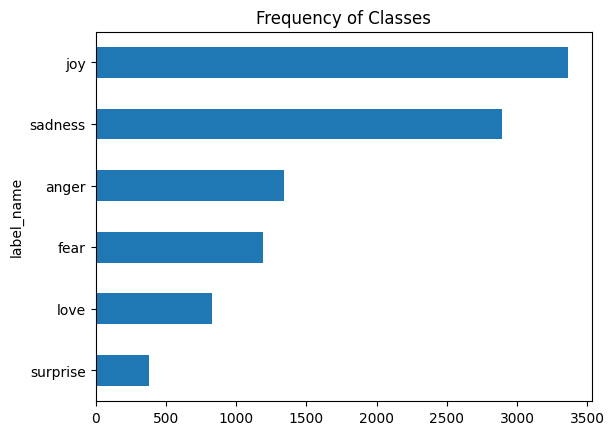

In [6]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

## Load a pretrained model

Chargeons maintenant un modèle Bert.

In [7]:
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**Exercice n°1: Tokenizez le dataset.**

In [8]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
emotions.set_format("pytorch")

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)
# emotions_encoded = <your code>

Commençons par regarder comment charger le Transformer seul:

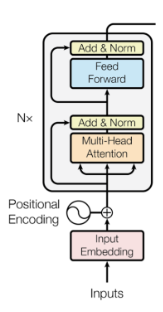

In [9]:
# hide_output
from transformers import AutoModel, AutoModelForSequenceClassification

headless_model = AutoModel.from_pretrained(model_ckpt)

2025-11-06 15:45:57.071038: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
headless_model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

**Exercice n°2: Chargez maintenant le modèle pour faire de la classification.**

Puis le Transformer avec un MLP pour faire la tâche de classification:

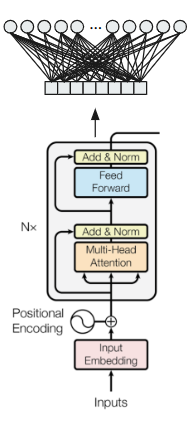

In [11]:
num_labels = len(emotions["validation"].features["label"].names)
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)
# model = <your code>

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Notez ci-dessus me message indiquant que les poids du MLP ne sont pas pré-entraînés.

In [12]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


Nous pouvons entraîner ce modèle sur le dataset chargé.

In [14]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  log_level="error")

In [15]:
from transformers import Trainer

from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

/tmp/ipykernel_79996/3421074140.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=training_args,


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.073900,0.532879,0.835000,0.820048
2,0.428600,0.343208,0.895000,0.892344


Regardons les performances sur le test set:

In [17]:
preds_output = trainer.predict(emotions_encoded["test"])
print(preds_output.metrics)
assert preds_output.metrics["test_accuracy"] >= 0.9

{'test_loss': 0.41485661268234253, 'test_accuracy': 0.9, 'test_f1': 0.8955555555555555, 'test_runtime': 0.0707, 'test_samples_per_second': 141.409, 'test_steps_per_second': 14.141}


# 2) Decoder-Only

Passons maintenant à un modèle Decoder-Only (aussi appelé Causal LM) avec GPT-2.

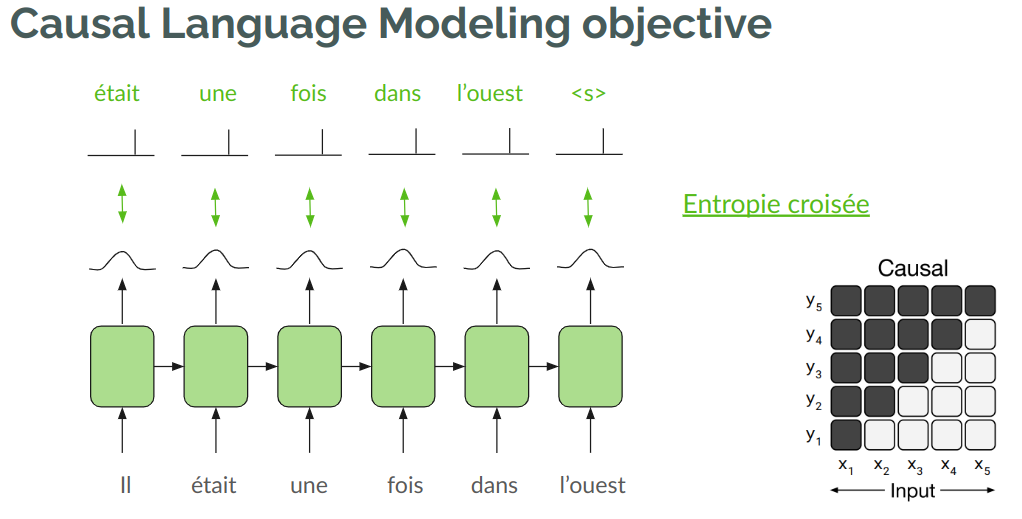

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "EleutherAI/pythia-70m"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
torch.manual_seed(42)

2025-11-06 17:09:21.984487: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Regardons maintenant les tokens les plus probables selon GPT-2 lorsqu'on lui donne en entrée la phrase "Transformers are the".

Essayez ensuite d'autres phrases (par exemple en Français).

In [22]:
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)
        # Select logits for the last token
        next_token_logits = output.logits[0, -1, :]
        # Apply softmax to get a normalized distribution
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)
        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (
                f"{tokenizer.decode(token_id)} ({100 * token_prob:.2f}%)"
            )
            iteration[f"Choice {choice_idx+1}"] = token_choice
        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

pd.DataFrame(iterations)

,input,Choice 1,Choice 2,Choice 3,Choice 4,Choice 5
0,Transformers are the,first (6.18%),only (4.89%),same (4.48%),most (3.82%),ones (1.73%)
1,Transformers are the first,to (7.78%),time (4.60%),of (2.88%),step (2.74%),and (1.66%)
2,Transformers are the first to,be (13.62%),use (5.84%),know (2.56%),make (2.24%),ever (2.00%)
3,Transformers are the first to be,able (6.95%),used (3.41%),the (1.92%),built (1.56%),transformed (1.49%)
4,Transformers are the first to be able,to (98.57%),\n (0.08%),", (0.07%)",be (0.07%),to (0.05%)
5,Transformers are the first to be able to,be (3.60%),use (3.18%),move (2.02%),create (1.87%),generate (1.63%)
6,Transformers are the first to be able to be,used (6.15%),transformed (2.53%),converted (2.16%),able (1.89%),re (1.49%)
7,Transformers are the first to be able to be used,in (26.36%),to (10.48%),for (8.76%),with (6.09%),. (5.94%)


Dans le morceau de code ci-dessus, le token le plus probable est utilisé pour continuer la phrase. Cette méthode est appelée Greedy Search Decoding.

## Greedy Search Decoding

La librairie transformers possède une méthode "generate" sur les Causal LMs permettant de continuer une phrase. Voici comment continuer la phrase avec du Greedy Search Decoding:

**Exercice n°3: Utilisez le greedy search decoding de generate.**

In [24]:
input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
max_new_tokens = 8
output = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=False)
# output = <your code>
generated_text = tokenizer.decode(output[0])
print(generated_text)
assert generated_text == "Transformers are the first to be able to be used in"

Transformers are the first to be able to be used in


En réalité, on a plutôt tendance à tirer un token de la distribution au lieu de choisir le plus probable. Il est possible de contrôler à quel point la distribution est piquée autour des tokens les plus probables grâce à un paramètre de température appliqué à la softmax.

## Sampling temperature

Regardons maintenant l'effet de la temperature sur les écarts de probabilité:

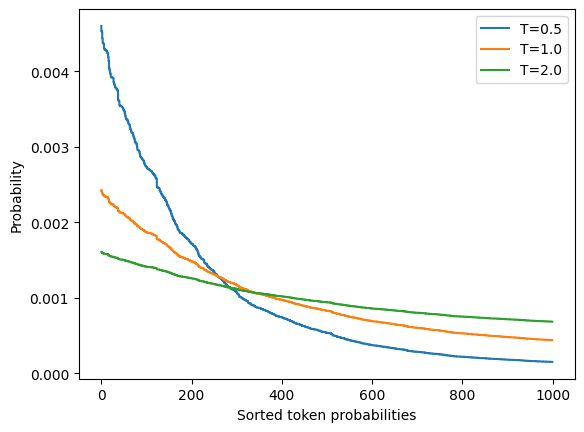

In [25]:
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")
plt.legend(loc="best")
plt.xlabel("Sorted token probabilities")
plt.ylabel("Probability")
plt.show()

Ainsi, une temperature > 1 rendra la distribution plus uniforme et une temperature entre 0 et 1 la rendra plus piquée.

Voici ce que ça donne avec notre modèle:

**Exercice n°4: Utilisez le sampling avec une temperature dans generate.**

In [29]:
outputs = []
for i in range(10):
    output_temp = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=True, temperature=2.0, top_k=0)
    outputs.append(tokenizer.decode(output_temp[0]))
# outputs.append(<your code>)
print(outputs)

['Transformers are the Best AwesomeMonitoryWorld!" MAR ACTION', 'Transformers are the strength “pde” APC command delay', 'Transformers are the single Carbon Tax adhere Story in IL Jiang', 'Transformers are the PCA055 –criminal 😉 splicing culp', 'Transformers are the Bod 296 accomart!\\ 9asetBound', 'Transformers are the basement permitized pint tobeto fired monomers', 'Transformers are thedetectors Event pitching as derived aftermath asynchron', 'Transformers are the frozen door SF cab flies advance750 destroys', 'Transformers are thewidget 24Sto TBI GO reconciliation Bend Workshop', 'Transformers are the top Ellis misses vicious motion regist2017→']


On peut aller encore plus loin. Le nombre de tokens possibles étant généralement très grand (e.g. 50000), il peut être souhaitable de se concentrer sur un sous-ensemble probable.

Pour cela, le Top-k et Top-p (aussi appelé Nucleus) sampling permettent d'échantillonner un token d'une distribution contenant seulement:
- les k tokens les plus probables (Top-k)
- le plus petit ensemble de tokens dont la somme des probabilités atteint p (Top-p)

## Top-k and Nucleus Sampling

In [30]:
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

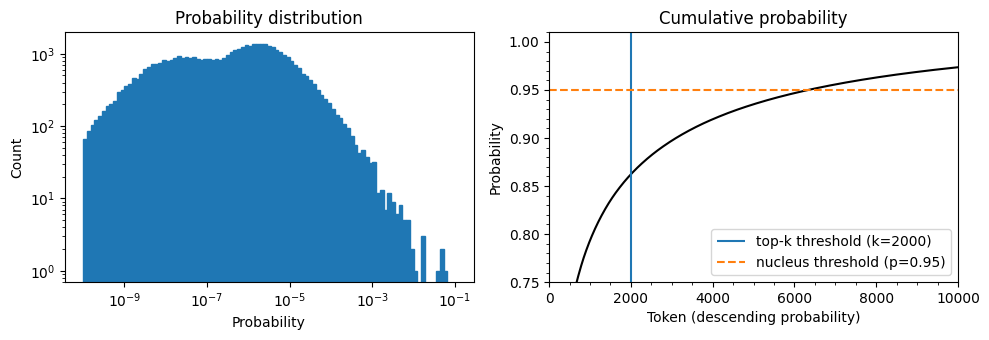

In [31]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distribution")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
#axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
#axes[1].grid(which="major")
axes[1].minorticks_on()
#axes[1].grid(which='minor', linewidth='0.5')
top_k_label = 'top-k threshold (k=2000)'
top_p_label = 'nucleus threshold (p=0.95)'
axes[1].vlines(x=2000, ymin=0, ymax=2, color='C0', label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color='C1', label=top_p_label, linestyle='--')
axes[1].legend(loc='lower right')
plt.tight_layout()

Testons avec notre modèle.

Commençons par un Top-k:

**Exercice n°5: Utilisez le Top-k sampling dans generate.**

In [32]:
outputs = []
for i in range(10):
    output_temp = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=True, top_k=50)
    outputs.append(tokenizer.decode(output_temp[0]))
# outputs.append(<your code>)
print(outputs)

['Transformers are the common elements between the two components.\n', 'Transformers are the default. In addition to receiving some input', 'Transformers are the ones that are able to use this feature', 'Transformers are the beginning of a lifetime.\n\nIn', 'Transformers are the same as\n\nThe bottom left panel', 'Transformers are the only way to get rid of the old', 'Transformers are the following:\n\\begin{eqnarray', 'Transformers are the simplest of those times with such precision.', 'Transformers are the most common applications for these materials. If', 'Transformers are the way to go but if you really want']


Puis le Top-p:

**Exercice n°6: Utilisez le Top-p sampling dans generate.**

In [33]:
outputs = []
for i in range(10):
    output_temp = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=True, top_p=0.90)
    outputs.append(tokenizer.decode(output_temp[0]))
# outputs.append(<your code>)
print(outputs)

['Transformers are the first-to-last part of the', "Transformers are the first one, and now it's up", 'Transformers are the original version of Windows. When you purchase', 'Transformers are the first line that is to have a "', 'Transformers are the key to be transformed to the new form', 'Transformers are the most expensive piece of technology ever. If', 'Transformers are the best part, but can we use them', 'Transformers are the only real thing on the web that would', 'Transformers are the largest and strongest with 20,500 mill', 'Transformers are the only remaining part of the web server that']


# 3) Instruction models

In [34]:
chat = [
    {"role": "system", "content": "You are a helpful science assistant."},
    {"role": "user", "content": "Hey, can you explain gravity to me?"}
]

**Exercice n°7: Utilisez ce chat comme input au modèle Qwen2.5-Coder-0.5B-Instruct.**

In [36]:
from transformers import pipeline

pipeline = pipeline(task="text-generation", model="Qwen/Qwen2.5-Coder-0.5B-Instruct", dtype="auto", device_map="auto")
response = pipeline(chat, max_new_tokens=512)
# response = <your code>
print(response[0]["generated_text"][-1]["content"])

Gravity is the force that pulls objects together and keeps them in balance. It is caused by the interaction of matter with air and water, and it is measured in Newtons (N). Gravity is an inverse property, meaning that if you have more mass than you need, the object will move faster.


Nous pouvons ensuite continuer la conversation:

In [38]:
chat = response[0]["generated_text"]
chat.append(
    {"role": "user", "content": "Woah! But can it be reconciled with quantum mechanics?"}
)
response = pipeline(chat, max_new_tokens=512)
print(response[0]["generated_text"][-1]["content"])

No, gravity cannot be reconciled with quantum mechanics. Quantum mechanics is a theory that deals with the behavior of particles at the atomic and subatomic level, while gravity is a force that is governed by the laws of physics. While quantum mechanics is a part of physics, it does not provide a direct explanation for why gravity behaves as it does.


# 4) Lightweight finetuning

Commençons par charger une version quantizée du modèle:

In [7]:
from transformers import AutoTokenizer, AutoModelForCausalLM
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-Coder-0.5B-Instruct", load_in_4bit=True)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In [4]:
from peft import get_peft_model, LoraConfig

**Exercice n°8: Obtenez maintenant le même modèle avec des adapters LoRA utilisant la config suivante.**

In [ ]:
lora_config = LoraConfig(
                r=16,
                lora_alpha=32,
                target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"], #, "lm_head"],
                lora_dropout=0,
                bias="none",
            )

In [5]:
model = get_peft_model(
        model,
        peft_config=lora_config
    )
# model = <your code>
model.print_trainable_parameters()

trainable params: 8,798,208 || all params: 502,830,976 || trainable%: 1.7497
